This notebook contains code to measure the burden of deleterious variation from STRs

In [36]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot as plt
import sys
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Simulation_functions import *

Populating the interactive namespace from numpy and matplotlib


In [37]:
calc_de_novo = False

In [38]:
# See /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/Generate_sample_info_txt.py for
# script extracting a sample's genotype information from the merged VCF "EUR_sans_FIN_filtered_w_sistr2_scores.vcf.gz" 
# that contains information regarding all samples

# Perform the following command to obtain genotypes for each STR for a given individual (only keep STRs with SISTR2 scores)
# Example command for individual NA12864
'''
awk 'NR==FNR{c[$1"a"$2]++;next};c[$1"a"$2] > 0 {print $1"\t"$2"\t"$3"\t"$4}' /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_allele_freqs_with_sistr2_scores_no_chr.txt /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/NA12864.txt > /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/NA12864_filtered.txt

'''

# Note - The file /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/EUR_sans_FIN_filtered_w_sistr2_scores.vcf.gz was obtained using the command: 
'''
bcftools view --regions-file /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_with_sistr2_scores.txt /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/EUR_sans_FIN_filtered.vcf.gz | bgzip -c > /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/EUR_sans_FIN_filtered_w_sistr2_scores.vcf.gz
'''

# Note - File with Per-locus scores
'''
/storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_sistr_per_locus_scores.txt

awk 'NR==FNR{c[$1"a"$2]++;next};c[$1"a"$2] > 0 {print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$6"\t"$7"\t"$8}' /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/NA10845_filtered.txt /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_sistr_per_locus_scores.txt > /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/NA10845_per_locus_scores_file.txt
'''

'\n/storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_sistr_per_locus_scores.txt\n\nawk \'NR==FNR{c[$1"a"$2]++;next};c[$1"a"$2] > 0 {print $1"\t"$2"\t"$3"\t"$4"\t"$5"\t"$6"\t"$7"\t"$8}\' /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/NA10845_filtered.txt /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_sistr_per_locus_scores.txt > /storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/NA10845_per_locus_scores_file.txt\n'

In [39]:
# Read in joint results
joint_results = {}
sistr2_scores_file = open('/storage/BonnieH/selection_project/analysis/SISTR2_scores_by_motif.txt', 'r')
sistr2_scores_file.readline()
for line in sistr2_scores_file:
    info = line.strip().split('\t')
    period = int(info[0])
    optimal_ru = int(info[1])
    motif = info[2]
    est_a = float(info[4])
    est_b = float(info[5])
    joint_results[(period,optimal_ru,motif)] = (est_a,est_b)
print(joint_results)
sistr2_scores_file.close()

{(2, 11, 'AT'): (0.6296529, 6.14e-05), (2, 12, 'AT'): (0.5882184, 3.17e-05), (2, 13, 'AT'): (0.2487026, 0.0002044), (2, 14, 'AT'): (0.8952737, 8.26e-05), (2, 15, 'AT'): (0.2537753, 8.02e-05), (2, 16, 'AT'): (0.8121238, 9.35e-05), (2, 17, 'AT'): (0.6352325, 7.09e-05), (2, 18, 'AT'): (0.0845467, 0.0002004), (2, 19, 'AT'): (0.9712703, 2.95e-05), (2, 20, 'AT'): (0.57922, 0.0002743), (2, 11, 'AG'): (0.873439, 0.0006798), (2, 12, 'AG'): (0.2238964, 0.002888), (2, 13, 'AG'): (0.4384836, 0.0001898), (2, 14, 'AG'): (0.0787858, 0.0053019), (2, 15, 'AG'): (0.0185307, 0.0008074), (2, 16, 'AG'): (0.2738581, 4.82e-05), (2, 17, 'AG'): (0.0361351, 0.003711), (2, 18, 'AG'): (0.3141738, 6.34e-05), (2, 19, 'AG'): (0.3057551, 9.16e-05), (2, 20, 'AG'): (0.5150636, 9.6e-05), (2, 11, 'AC'): (0.0935982, 0.0013493), (2, 12, 'AC'): (0.0704712, 0.0002003), (2, 13, 'AC'): (0.3592225, 0.0001424), (2, 14, 'AC'): (0.8744295, 6.03e-05), (2, 15, 'AC'): (0.8798988, 0.0002187), (2, 16, 'AC'): (0.2907548, 0.0004035), (2,

In [40]:
sample = 'NA12864' # Change sample name based on the sample you would like to analyze
use_joint = True
# Calculate burden from standing variation using joint or per locus scores
sample_info_file = open('/storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/' + sample + '_filtered.txt', 'r') 

# Change sistr_scores_file variable according to whether want to use joint or per locus scores

# Joint scores
if use_joint == True:
    sistr_scores_file = open('/storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/1kg_allele_freqs_with_sistr2_scores_no_chr.txt', 'r')

# Per-locus scores
if use_joint == False:
    sistr_scores_file = open('/storage/BonnieH/selection_project/1000genomes/euro_allele_freqs/'+sample+'_per_locus_scores_file.txt', 'r')

# Column headers for above file: chrom, pos, per, optimal allele, motif
#sample_info_file.readline()
#sistr_scores_file.readline()

burden_list_joint = [] # List of burdens
diff_list = [] # List of differences between optimal allele and individual's genotype
count_loci = 0

burden_by_class = {}
for line1, line2 in zip(sistr_scores_file, sample_info_file):
    
    cont = True
    # Get information from line - joint scores file
    if use_joint == True:
        info = line1.strip().split('\t')
        chrom = info[0]
        start = int(info[1])
        per = int(info[2])
        opt_allele = int(info[3])
        motif = info[4]
    
    # Get information from line - per locus scores file
    if use_joint == False:
        info = line1.strip().split('\t')
        chrom = info[0]
        start = int(info[1])
        per = int(info[4])
        opt_allele = int(info[5])
        motif = info[6]
        s_val = info[7]
        if s_val == 'N/A':
            cont = False
            #print('NA sval')
        else:
            s_val = float(info[7])
    
    if cont == True: 
        
        info = line2.strip().split('\t')
        chromosome = info[0]
        pos = int(info[1])
        if chromosome != chrom or start != pos:
            print('Does not match')
            print((chrom, chromosome))
            print((start, pos))
        geno1 = int(info[2])
        geno2 = int(info[3])
        
        if geno1 != 0 and geno2 != 0:
            
            count_variant_alleles = 0
            count_loci = count_loci + 1
            diff1 = geno1 - opt_allele
            diff2 = geno2 - opt_allele
            if diff1 != 0:
                diff_list.append(diff1)
                count_variant_alleles = count_variant_alleles + 1
            if diff2 != 0:
                diff_list.append(diff2)
                count_variant_alleles = count_variant_alleles + 1

            # Calculate burden

            if (per, opt_allele, motif) in joint_results:
                
                # Joint scores
                if use_joint == True:
                    a = joint_results[(per, opt_allele, motif)][0]
                    b = joint_results[(per, opt_allele, motif)][1]
                    s_val = a*b
                #s_val = np.random.gamma(a, b)
                #if s_val > 1:
                    #s_val = 1
                
                burden1 = abs(diff1*s_val)
                burden2 = abs(diff2*s_val)
                if burden1 > 1:
                    burden1 = 1
                if burden2 > 1:
                    burden2 = 1
                if diff1 != 0:
                    if burden1 < 10**-5:
                        burden1 = 0
                    burden_list_joint.append(burden1)
                if diff2 != 0:
                    if burden2 < 10**-5:
                        burden2 = 0
                    burden_list_joint.append(burden2)
                    
                if (motif, opt_allele) not in burden_by_class:
                    burden_by_class[(motif, opt_allele)] = [2, count_variant_alleles, burden1 + burden2, s_val]
                    
                else:
                    burden_by_class[(motif, opt_allele)][0] = burden_by_class[(motif, opt_allele)][0] + 2
                    burden_by_class[(motif, opt_allele)][1] = burden_by_class[(motif, opt_allele)][1] + count_variant_alleles
                    burden_by_class[(motif, opt_allele)][2] = burden_by_class[(motif,opt_allele)][2] + burden1 + burden2
                    
    
sistr_scores_file.close()
sample_info_file.close()

print("%s STR Reduction in Fitness" %(sample))
print("Standing variation burden = %.2f (Calculated from %d alleles)" %(np.sum(burden_list_joint), len(burden_list_joint)))
print("Total number of alleles: %d" %(count_loci*2))


# Write burden results to file
results_file = open(sample+"_inherited_burden_upd.txt","w")
results_file.write("Variation from optimal allele" + "\t" + "Inherited burden" + "\n")
for i in range(0, len(burden_list_joint)):
    results_file.write(str(diff_list[i])+"\t"+str(burden_list_joint[i])+"\n")
results_file.close()


'''
# Write results by class to file
if use_joint == True:
    results_file = open(sample+"_burden_by_class.txt","w")
else: 
    results_file = open(sample+"_burden_by_class_per_locus.txt","w")
results_file.write("Motif" + "\t" + "Optimal_allele" + "\t" + "Total_num_alleles" + "\t" + "Num_variant_alleles" + "\t" + "Burden" + "\t" + "Expected_s_value" + "\n")
for str_class in burden_by_class:
    results_file.write(str(str_class[0])+"\t"+str(str_class[1])+"\t"+str(burden_by_class[str_class][0])+"\t"+str(burden_by_class[str_class][1])+"\t"+str(burden_by_class[str_class][2])+"\t"+str(burden_by_class[str_class][3])+"\n")
results_file.close()
'''

NA12864 STR Reduction in Fitness
Standing variation burden = 54.95 (Calculated from 35620 alleles)
Total number of alleles: 147548


'\n# Write results by class to file\nif use_joint == True:\n    results_file = open(sample+"_burden_by_class.txt","w")\nelse: \n    results_file = open(sample+"_burden_by_class_per_locus.txt","w")\nresults_file.write("Motif" + "\t" + "Optimal_allele" + "\t" + "Total_num_alleles" + "\t" + "Num_variant_alleles" + "\t" + "Burden" + "\t" + "Expected_s_value" + "\n")\nfor str_class in burden_by_class:\n    results_file.write(str(str_class[0])+"\t"+str(str_class[1])+"\t"+str(burden_by_class[str_class][0])+"\t"+str(burden_by_class[str_class][1])+"\t"+str(burden_by_class[str_class][2])+"\t"+str(burden_by_class[str_class][3])+"\n")\nresults_file.close()\n'

Text(0.5, 1.0, 'NA12864 \n Number of alleles with variation: 35620/147548')

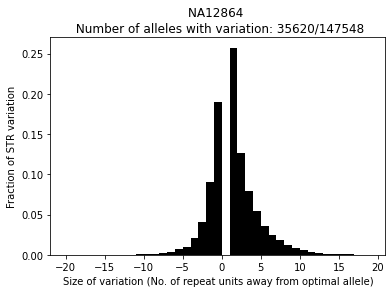

In [41]:
plt.hist(diff_list, color='black', bins = np.arange(-20,20,1), weights = np.ones_like(diff_list)/len(diff_list))
plt.xlabel('Size of variation (No. of repeat units away from optimal allele)')
plt.ylabel('Fraction of STR variation')
plt.title('%s \n Number of alleles with variation: %d/%d'%(sample, len(diff_list), count_loci*2))
#print(diff_list)

In [42]:
# Calculate burden of de novo mutations from model: Burden_de_novo=Num_loci*2*(P(mutation_i_units)*s*i)

if calc_de_novo == True:

    # List contents: mu, beta, p, l, optimal ru for the mu value
    # Mutation model parameters for different motifs
    motif_info = {}
    motif_info['eurodem_prior2_dinuc_e_1kg_euro'] = [10**-5, 0.3, 0.6, 0.15, 6]
    motif_info['eurodem_prior2_dinuc_d_1kg_euro'] = [10**-4.6, 0.3, 0.6, 0.135, 6]
    motif_info['eurodem_prior2_trinuc_e_1kg_euro'] = [10**-6, 0.3, 0.9, 0.3, 5] 
    motif_info['eurodem_prior2_tetranuc_b_1kg_euro'] = [10**-5, 0.3, 0.9, 0.25, 3]
    motif_info['eurodem_prior2_tetranuc_c_1kg_euro'] = [10**-5.5, 0.3, 0.9, 0.42, 3]
    motif_info['eurodem_prior2_tetranuc_d_1kg_euro'] = [10**-6, 0.3, 0.9, 0.45, 3]
    
    # Mutation model settings for different motifs (inferred by SISTR2)
    trinuc_motifs = ['ACC','AGG','AGC','CCG','AAG','AAC','ATC','AAT']
    dinuc_motifs  = ['AC','AG','AT'] 
    tetranuc_motifs = ['AAGG','AAAT','ATCC','AATC','AAAC','AATG','ACAT','AGAT','AAAG'] 
    mut_setting = {}
    mut_setting['AC'] = 'eurodem_prior2_dinuc_e_1kg_euro'
    mut_setting['AG'] = 'eurodem_prior2_dinuc_e_1kg_euro'
    mut_setting['AT'] = 'eurodem_prior2_dinuc_d_1kg_euro'
    for mot in trinuc_motifs:
        mut_setting[mot] = 'eurodem_prior2_trinuc_e_1kg_euro'
    for mot in ['AAAG', 'AAGG', 'AGAT']:
        mut_setting[mot] = 'eurodem_prior2_tetranuc_b_1kg_euro'
    for mot in ['ACAT', 'AAAT']:
        mut_setting[mot] = 'eurodem_prior2_tetranuc_c_1kg_euro'
    for mot in ['AATC', 'AATG', 'ATCC', 'AAAC']:
        mut_setting[mot] = 'eurodem_prior2_tetranuc_d_1kg_euro'
    
    # Read in joint results
    joint_results = {}
    sistr2_scores_file = open('/storage/BonnieH/selection_project/analysis/SISTR2_scores_by_motif_corrected_num_loci.txt', 'r')
    sistr2_scores_file.readline()
    for line in sistr2_scores_file:
        info = line.strip().split('\t')
        period = int(info[0])
        optimal_ru = int(info[1])
        motif = info[2]
        num_loci = int(info[3])
        est_a = float(info[4])
        est_b = float(info[5])
        joint_results[(period,optimal_ru,motif,num_loci)] = (est_a,est_b)
    #print(joint_results)
    sistr2_scores_file.close()
    
    # Keep track of burdens for each motif
    burden_for_each_motif = {}
    for motif in trinuc_motifs:
        burden_for_each_motif[motif] = []
    for motif in dinuc_motifs:
        burden_for_each_motif[motif] = []
    for motif in tetranuc_motifs:
        burden_for_each_motif[motif] = []
    
    # Calculate de novo burden
    de_novo_burden = 0
    for elem in joint_results:
        num_loci = elem[3]
        for i in range(-20, 20):
            setting_info = mut_setting[elem[2]]
            mut_info = motif_info[setting_info]
            
            # Calculate mu
            log_mu_prime = np.log10(mut_info[0])+mut_info[3]*(elem[1] - mut_info[4])
            mu_prime = 10**log_mu_prime
            if mu_prime < 10**-8: mu_prime = 10**-8 
            if mu_prime > 10**-3: mu_prime = 10**-3
                
            # Get probability of mutation and calculate de novo burden
            if elem[1] + i > 0:
                # beta = mut_info[1]
                # p = mut_info[2]
                prob_mutation = GetStepSizeProb(0, i, mut_info[1], mut_info[2])
                prob_mutation = prob_mutation * mu_prime
                de_novo_burden = de_novo_burden + num_loci*2*prob_mutation*joint_results[elem][0]*joint_results[elem][1]*abs(i)
                burden_for_each_motif[elem[2]].append(num_loci*2*prob_mutation*joint_results[elem][0]*joint_results[elem][1]*abs(i))
                
                # Note: Num_loci*2*(P(mutation_i_units)*s*i) = num_loci*2*prob_mutation*joint_results[elem][0]*joint_results[elem][1]*abs(i)
                # s is calculated as E[s] = a*b in gamma distribution
                
    print(de_novo_burden)
    sum_burdens = []
    for motif in burden_for_each_motif:
        print(motif)
        print(sum(burden_for_each_motif[motif]))
        sum_burdens.append(sum(burden_for_each_motif[motif]))
    print(sum(sum_burdens))
    #print(burden_for_each_motif)